<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classification-VIT/classification_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import os  # For file and directory operations
import numpy as np   # For numerical operations and array manipulations
import pandas as pd  # For handling tabular data and CSV files
from tensorflow.keras.preprocessing import image  # For image processing
import cv2  # OpenCV library for advanced image processing techniques like histogram equalization
import tensorflow as tf  # Tensorflow library for data augmentation
from collections import Counter  # For counting occurrences of labels
from sklearn.utils import resample  # For oversampling to balance the dataset
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For statistical data visualization

Defining image size and number of classes

In [ ]:
# ================================ CONFIGURATION ================================
IMG_SIZE = 224  # Resize all images to 224x224
NUM_CLASSES = 16  # Total number of tumor classes (including 'No Tumor')

Load Dataset and Define a ouput directory

In [ ]:
# Paths
IMAGE_DIR = '/content/drive/MyDrive/DSGP_BrainTumorDetection/DSGP_dataset'  # Input dataset
SAVE_DIR = '/content/drive/MyDrive/DSGP_BrainTumorDetection/Preprocessed_Dataset_classification'  # Output folder
os.makedirs(SAVE_DIR, exist_ok=True)  # Create the output directory if it does not exist

Defining label map for the dataset

In [ ]:
# Updated label map based on dataset structure
label_map = {
    'Astrocitoma': 0, 'Carcinoma': 1, 'Ependimoma': 2, 'Ganglioglioma': 3,
    'Germinoma': 4, 'Glioblastoma': 5, 'Granuloma': 6, 'Meduloblastoma': 7,
    'Neurocitoma': 8, 'Oligodendroglioma': 9, 'Papiloma': 10, 'Schwannoma': 11,
    'Tuberculoma': 12, 'meningioma': 13, 'pituitary': 14, 'no tumour': 15
}

EDA and Visualization

In [ ]:
def perform_eda(image_paths, image_labels):
    """
    Perform Exploratory Data Analysis and visualize dataset characteristics.
    """
    # Plot class distribution
    class_counts = Counter(image_labels)
    class_names = [list(label_map.keys())[list(label_map.values()).index(cls)] for cls in class_counts.keys()]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_names, y=list(class_counts.values()), palette='viridis')
    plt.title('Class Distribution', fontsize=16)
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Analyze image dimensions
    img_shapes = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_shapes.append(img.shape)

    # Convert dimensions to pandas DataFrame for analysis
    img_shapes_df = pd.DataFrame(img_shapes, columns=['Height', 'Width'])
    print(img_shapes_df.describe())  # Print basic statistics

    # Visualize image size distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(img_shapes_df['Height'], kde=True, color='blue', label='Height', bins=30)
    sns.histplot(img_shapes_df['Width'], kde=True, color='orange', label='Width', bins=30)
    plt.title('Image Size Distribution', fontsize=16)
    plt.xlabel('Pixels', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Display sample images from each class
    plt.figure(figsize=(16, 10))
    unique_classes = list(label_map.keys())
    for i, class_name in enumerate(unique_classes):
        class_imgs = [path for path, label in zip(image_paths, image_labels) if label == label_map[class_name]]
        if len(class_imgs) > 0:
            img = cv2.imread(class_imgs[0], cv2.IMREAD_GRAYSCALE)
            plt.subplot(1, len(unique_classes), i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(class_name)
            plt.axis('off')
    plt.suptitle('Sample Images from Each Class', fontsize=18)
    plt.tight_layout()
    plt.show()

Data Augmentation

In [ ]:
# Define a sequential model for applying various data augmentation techniques

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),  # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.2),  # Apply random rotations up to 25%
    tf.keras.layers.RandomZoom(0.2),  # Randomly zoom into the image
    tf.keras.layers.RandomWidth(0.2),   # Randomly adjust image width
    tf.keras.layers.RandomHeight(0.2),  # Randomly adjust image height
    tf.keras.layers.RandomContrast(0.2),  # Apply random contrast adjustments
    tf.keras.layers.RandomBrightness(0.2)  # Apply random brightness adjustments
])

Function to load and anugment image

In [ ]:
def load_and_augment_image(image_path, label):
    """
    Load, preprocess, and augment a single image.
    """
    # Load and convert image to grayscale
    img = image.load_img(image_path, color_mode="grayscale", target_size=(IMG_SIZE, IMG_SIZE))
    img_data = image.img_to_array(img)

    # Preprocess and augment
    img_data = preprocess_image(img_data)
    img_data = data_augmentation(tf.convert_to_tensor(img_data[None, ...]))[0].numpy()

    return img_data, label

Function to load and balance the dataset

In [ ]:
def load_and_balance_dataset(image_dir):
    """
    Load images and balance the dataset using oversampling.
    """
    image_paths = []
    image_labels = []

    # Walk through directories to collect images
    for root, _, files in os.walk(image_dir):
        label_name = os.path.basename(root)
        if label_name in label_map:
            for img_name in files:
                img_path = os.path.join(root, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image formats
                    image_paths.append(img_path)
                    image_labels.append(label_map[label_name])

    image_paths = np.array(image_paths)
    image_labels = np.array(image_labels)

    # Perform EDA before balancing
    perform_eda(image_paths, image_labels)

    # Balance classes using oversampling
    class_counts = Counter(image_labels)
    max_count = max(class_counts.values())
    print(f"Original class distribution: {class_counts}")

    balanced_image_paths, balanced_image_labels = [], []
    for class_label in class_counts.keys():
        class_indices = np.where(image_labels == class_label)[0]
        resampled_paths, resampled_labels = resample(
            image_paths[class_indices], [class_label] * len(class_indices),
            replace=True, n_samples=max_count, random_state=42
        )
        balanced_image_paths.extend(resampled_paths)
        balanced_image_labels.extend(resampled_labels)

    print(f"Balanced class distribution: {Counter(balanced_image_labels)}")
    return np.array(balanced_image_paths), np.array(balanced_image_labels)

Function to preprocess images

In [ ]:
def preprocess_image(img_data):
    """
    Preprocess the image: Resize, histogram equalization, normalization, CLAHE, and Gaussian noise.
    """
    img_resized = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
    img_resized = img_resized.astype(np.uint8)  # Ensure 8-bit

    # Histogram Equalization
    img_equalized = cv2.equalizeHist(img_resized)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_equalized)

    # Add Gaussian Noise
    noise = np.random.normal(0, 0.05, img_clahe.shape)
    img_noisy = np.clip(img_clahe + noise, 0, 255)  # Clip to valid range

    # Normalize pixel values
    img_normalized = img_noisy / 255.0
    return img_normalized

Function to Save preprocessed data

In [ ]:
def preprocess_and_save_dataset(image_paths, labels, save_dir):
    """
    Preprocess and save the dataset to disk in the original directory structure.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Loop over image paths and save them in the original folder structure
    for i, img_path in enumerate(image_paths):
        label_name = list(label_map.keys())[list(label_map.values()).index(labels[i])]
        class_dir = os.path.join(save_dir, label_name)
        os.makedirs(class_dir, exist_ok=True)

        # Load and preprocess the image
        img = image.load_img(img_path, color_mode="grayscale", target_size=(IMG_SIZE, IMG_SIZE))
        img_data = image.img_to_array(img)
        img_data = preprocess_image(img_data)

        # Reshape to add channel dimension for grayscale if necessary
        img_data = img_data.reshape((img_data.shape[0], img_data.shape[1], 1))  # Add channel dimension

        # Check if the image is properly reshaped and the correct format is being saved
        if img_data.shape[-1] == 1:  # Grayscale image, single channel
            save_path = os.path.join(class_dir, f'image_{i}.png')  # Save as PNG for grayscale images
        else:  # For RGB images
            save_path = os.path.join(class_dir, f'image_{i}.jpg')  # JPG for RGB

        # Save the image
        try:
            image.save_img(save_path, img_data)
            print(f"Saved image {i} to {save_path}")
        except Exception as e:
            print(f"Error saving image {i} to {save_path}: {e}")

    # Optionally, save a label CSV if needed
    label_file = os.path.join(save_dir, 'labels.csv')
    pd.DataFrame({'image_path': image_paths, 'label': labels}).to_csv(label_file, index=False)
    print(f"Preprocessed data saved in {save_dir}")

Execution of the process

<ipython-input-12-233a7a37dddb>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=list(class_counts.values()), palette='viridis')


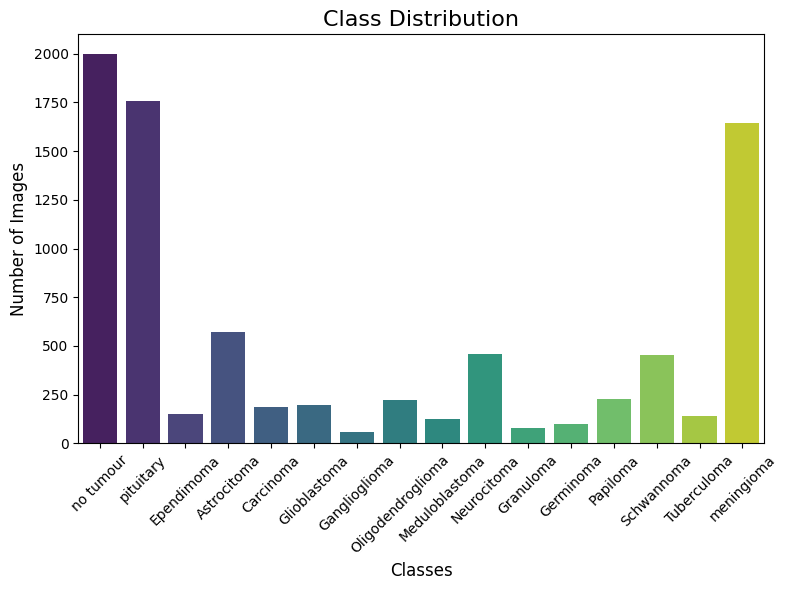

            Height        Width
count  8364.000000  8364.000000
mean    494.691176   479.090626
std     144.346838   143.714022
min     168.000000   150.000000
25%     500.000000   441.000000
50%     512.000000   512.000000
75%     630.000000   571.000000
max    1446.000000  1920.000000


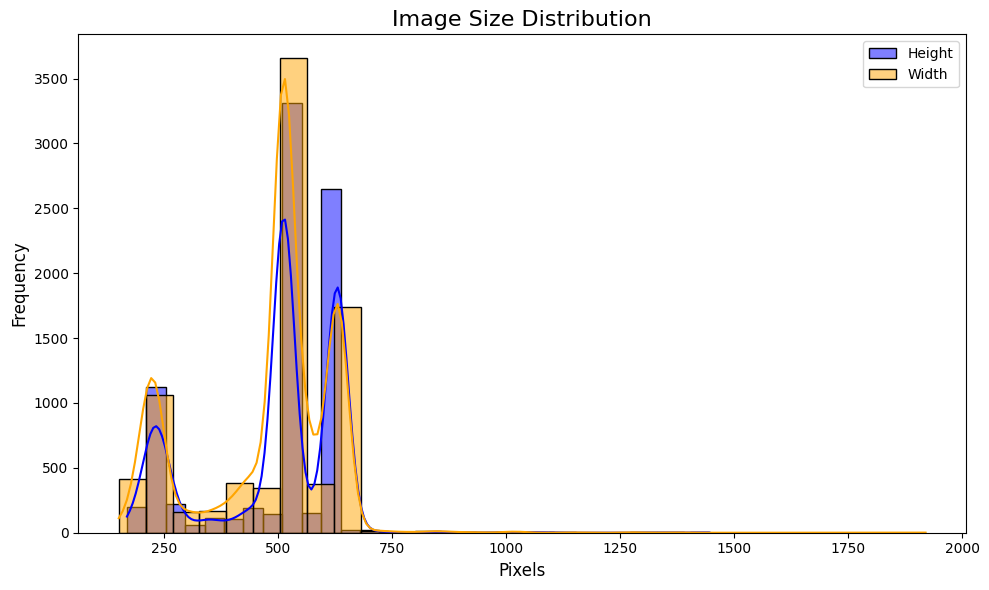

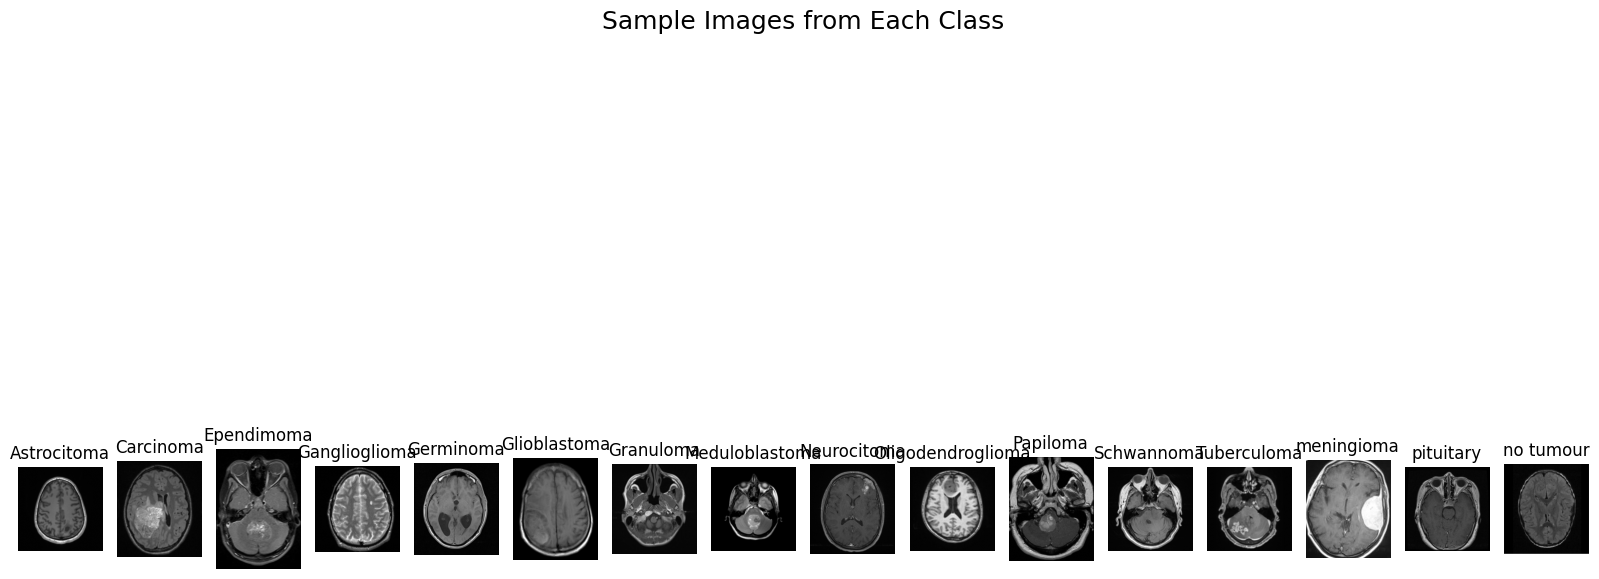

Streaming output truncated to the last 5000 lines.
  adding: content/drive/MyDrive/DSGP_BrainTumorDetection/Preprocessed_Dataset_classification/Schwannoma/image_27003.png (deflated 0%)
  adding: content/drive/MyDrive/DSGP_BrainTumorDetection/Preprocessed_Dataset_classification/Schwannoma/image_27004.png (deflated 0%)
  adding: content/drive/MyDrive/DSGP_BrainTumorDetection/Preprocessed_Dataset_classification/Schwannoma/image_27005.png (deflated 0%)
  adding: content/drive/MyDrive/DSGP_BrainTumorDetection/Preprocessed_Dataset_classification/Schwannoma/image_27006.png (stored 0%)
  adding: content/drive/MyDrive/DSGP_BrainTumorDetection/Preprocessed_Dataset_classification/Schwannoma/image_27007.png (deflated 0%)
  adding: content/drive/MyDrive/DSGP_BrainTumorDetection/Preprocessed_Dataset_classification/Schwannoma/image_27008.png (deflated 0%)
  adding: content/drive/MyDrive/DSGP_BrainTumorDetection/Preprocessed_Dataset_classification/Schwannoma/image_27009.png (stored 0%)
  adding: conte

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ================================ MAIN FUNCTION ================================
def preprocess_and_download(image_dir):
    """
    Main function to preprocess, balance, and save the dataset.
    """
    # Load and balance dataset
    image_paths, image_labels = load_and_balance_dataset(image_dir)

    # Preprocess and save the full dataset (without splitting)
    print("Processing and saving dataset...")
    preprocess_and_save_dataset(image_paths, image_labels, SAVE_DIR)

    # Compress the dataset for download (zip original structure)
    print("Compressing dataset for download...")
    !zip -r Preprocessed_Dataset.zip "{SAVE_DIR}"
    from google.colab import files
    files.download('Preprocessed_Dataset.zip')

# ================================ EXECUTION ================================
# Start preprocessing and downloading
preprocess_and_download(IMAGE_DIR)